# Detecting illimination conditions in face images in Extended YaleB.

First try classical approach https://www.kaggle.com/tbourton/illumination-classification applied to this dataset, then a CNN approach.

In [1]:
import os
import glob
import itertools
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm.notebook as tqdm

from sklearn.ensemble import RandomForestClassifier
from skimage.measure import shannon_entropy
from sklearn.metrics import classification_report as cr, confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

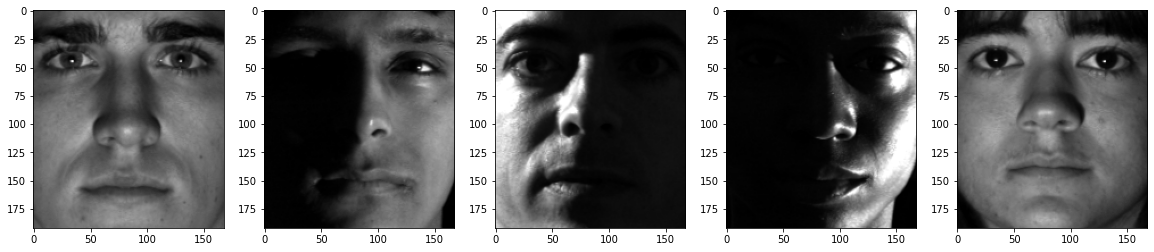

In [2]:
random.seed(0)
files = glob.glob('/kaggle/input/extyalebcroppedpng/CroppedYalePNG/*.png')
files = [file_ for file_ in files if 'Ambient' not in os.path.basename(file_)]
files = sorted(files)
random.shuffle(files)

random.seed()
k = 5
fig, axs = plt.subplots(1, k, figsize=(20, int(20 / k)))
for ax, file_ in zip(axs, random.choices(files, k=k)):
    ax.imshow(cv2.imread(file_, cv2.IMREAD_UNCHANGED), cmap='gray')
plt.show()

random.seed(0)

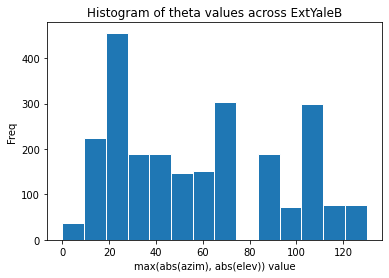

In [3]:
# The data is labelled by azimuth and elevation angles of the light source w.r.t to the camera
# In the end we only care about the max(abs(azim), abs(elev))

def get_max_azim_elev(file_):
    base = os.path.basename(file_)
    base = os.path.splitext(base)[0]
    azim, elev = base.split('_')[-1].split('A')[-1].split('E')
    azim, elev = int(azim), int(elev)
    return max(abs(azim), abs(elev))

thetas = list(map(get_max_azim_elev, files))
thetas = np.array(thetas)

assert len(thetas) == len(files)
assert min(thetas) >= 0
assert max(thetas) <= 180

fig = plt.figure()
plt.hist(thetas, bins='auto', histtype='bar', ec='white')
plt.xlabel('max(abs(azim), abs(elev)) value')
plt.ylabel('Freq')
plt.title("Histogram of theta values across ExtYaleB")
plt.show()

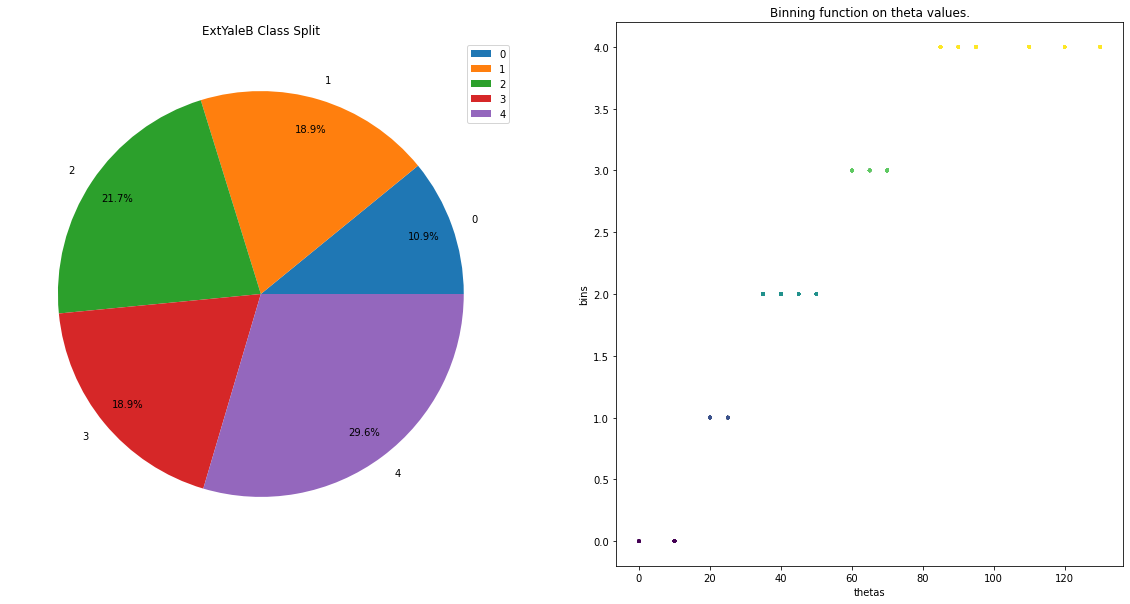

In [4]:
# Following Sec 4.3 https://arxiv.org/pdf/1606.02894.pdf we bin the angles
# Our bins are the same as theirs (subsets), shifted by -1
# 0 is most illuminates, 4 the least

# Extract the class labels from the thetas
def bin_theta(theta):
    if theta < 12:
        return 0
    elif 20 <= theta <= 25:
        return 1
    elif 35 <= theta <= 50:
        return 2
    elif 60 <= theta < 77:
        return 3
    elif theta > 77:
        return 4
    else:
        raise ValueError
        
y = np.array(list(map(bin_theta, thetas)))
assert min(y) == 0
assert max(y) == 4
assert len(y) == len(files)

unq, unq_cnts = np.unique(y, return_counts=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.pie(unq_cnts, rotatelabels=False, labels=unq, autopct='%1.1f%%', pctdistance=0.85)
ax1.legend()
ax1.set_title('ExtYaleB Class Split')

ax2.scatter(thetas, y, s=5, c=y)
ax2.set(xlabel='thetas', ylabel='bins')
ax2.set_title('Binning function on theta values.')
plt.show()

In [5]:
# Extract the features that we want to use

def nric(img):
    """Extract the no reference features from image.
    
    Parameters
    ----------
    img: np.ndarray or path-like
        Grayscale image or path to image.
    
    Returns
    -------
    float
        The shannon entropy of the grayscale image.
    float
        The standard deviation of the grayscale image.
    float
        The mean of the grayscale image.
        
    """
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        
    sd = np.std(img)
    me = np.mean(img)
    se = shannon_entropy(img)
    return se, sd, me

x = np.array(list(map(nric, tqdm.tqdm(files))))
assert len(x) == len(y)

  0%|          | 0/2414 [00:00<?, ?it/s]

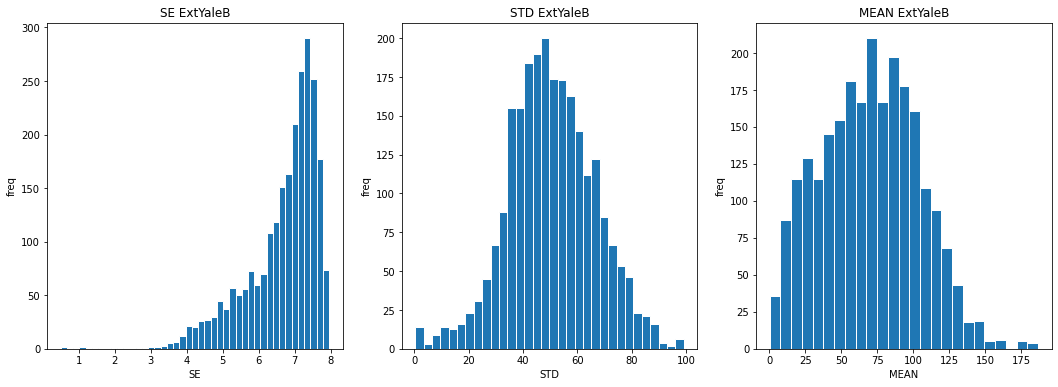

Metric Avg | Class 0 | Class 1 | Class 2 | Class 3 | Class 4
SE 7.314052691821233 7.408779979561025 7.274203420151282 6.694933790239838 5.430912034896301
STD 41.32915365888287 45.47320168203362 53.5858522282237 62.68236211845505 46.71320288244958
MEAN 108.54289342578761 101.68172955174394 79.5088143660242 61.30793244232543 32.61204468766674


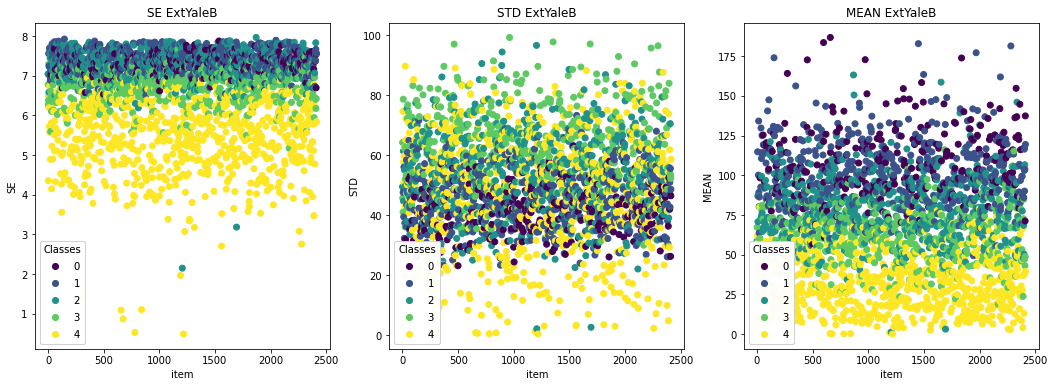

In [6]:
FEATURE_NAMES = ['SE', 'STD', 'MEAN']
k = len(FEATURE_NAMES)

fig, ax = plt.subplots(1, k, figsize=(18, 18/k))
for i, q in enumerate(FEATURE_NAMES):
    ax[i].hist(x[:, i], bins='auto', histtype='bar', ec='white')
    ax[i].set(xlabel=q, ylabel="freq")
    ax[i].set_title(q + ' ExtYaleB')
plt.show()

print('Metric Avg | Class 0 | Class 1 | Class 2 | Class 3 | Class 4')
fig, ax = plt.subplots(1, k, figsize=(18, 18/k))
for i, q in enumerate(['SE', 'STD', 'MEAN']):
    scatter = ax[i].scatter(np.arange(0, len(y)), x[:, i], c=y)
    legend = ax[i].legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax[i].add_artist(legend)
    ax[i].set(xlabel='item', ylabel=q)
    ax[i].set_title(q + ' ExtYaleB')
    print(q, *[x[y == c][:, i].mean() for c in unq])
plt.show()

In [7]:
# Train RF
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

clf = RandomForestClassifier(random_state=0, class_weight='balanced')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(cr(y_true=y_test, y_pred=y_pred))
print(cm(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.59      0.49      0.54        53
           1       0.62      0.66      0.64        91
           2       0.79      0.82      0.80       105
           3       0.78      0.80      0.79        91
           4       0.91      0.89      0.90       143

    accuracy                           0.77       483
   macro avg       0.74      0.73      0.73       483
weighted avg       0.77      0.77      0.77       483

[[ 26  24   3   0   0]
 [ 17  60  14   0   0]
 [  1  13  86   5   0]
 [  0   0   6  73  12]
 [  0   0   0  16 127]]


# Trying a simple CNN

In [8]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
DATASET_SIZE = len(files)
IMG_SIZE = 300
NUM_CLASSES = len(unq)
VAL_FRAC = 0.1
TEST_FRAC = 0.1

assert NUM_CLASSES == 5

# One-hot encode labels
labels = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES, dtype='float32')
files = np.array(files)
assert DATASET_SIZE == len(labels) == len(files)

In [9]:
# Train/Test/Val splits
train_size = int((1 - VAL_FRAC - TEST_FRAC) * DATASET_SIZE)
val_size = int(VAL_FRAC * DATASET_SIZE)
test_size = int(TEST_FRAC * DATASET_SIZE)

random.seed(0)
indices = list(range(DATASET_SIZE))
random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size: train_size + val_size]
test_indices = indices[train_size + val_size:]

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


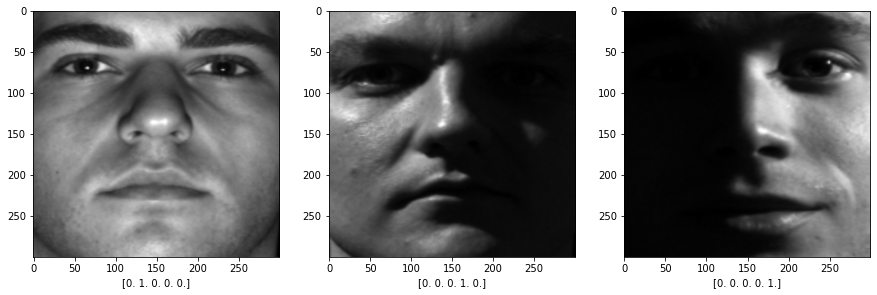

In [10]:
# Dataset creation
train_data = tf.data.Dataset.from_tensor_slices((files[train_indices], labels[train_indices]))
val_data = tf.data.Dataset.from_tensor_slices((files[val_indices], labels[val_indices]))
test_data = tf.data.Dataset.from_tensor_slices((files[test_indices], labels[test_indices]))

assert len(train_data) == len(train_indices)
assert len(val_data) == len(val_indices)
assert len(test_data) == len(test_indices)
assert len(test_data) + len(train_data) + len(val_data) == DATASET_SIZE

# Read files
def map_fn(path, label):
    image = tf.io.decode_png(tf.io.read_file(path), channels=1)  # use 3 channels so we can feed to network
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.grayscale_to_rgb(image)
    return image, label


train_data = train_data.map(lambda path, lbl: map_fn(path, lbl), num_parallel_calls=AUTOTUNE)
val_data = val_data.map(lambda path, lbl: map_fn(path, lbl), num_parallel_calls=AUTOTUNE)
test_data = test_data.map(lambda path, lbl: map_fn(path, lbl), num_parallel_calls=AUTOTUNE)

# Performance enchancement - cache, full shuffle, batch, prefetch
train_data = train_data.cache().shuffle(len(train_data)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Display some
imgs, lbls = list(train_data.take(1))[0]
n = 3
fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
for i, (img, lbl) in enumerate(zip(imgs[:n], lbls[:n])):
    ax[i].imshow(cv2.cvtColor(img.numpy(), cv2.COLOR_RGB2GRAY), cmap='gray')
    ax[i].set(xlabel=lbl.numpy())

plt.show()

In [11]:
# Define model and pre-processing layers

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Size should ideally be 300
# Network already rescales https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/applications/efficientnet.py#L320
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg"
)

base_model.trainable = False

43941888/43941136 [==============================] - 1s 0us/step


In [12]:
# Model definition
inputs = x = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(x)
x = preprocess_input(x)
x = base_model(x, training = False)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=NUM_CLASSES, activation="softmax", name="pred_light")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

# Small check
imgs, lbls = list(val_data.take(1))[0]
pred = model(imgs, training=False)

assert lbls.shape == pred.shape

In [13]:
LEARNING_RATE = 1e-3

model.compile(
    optimizer=tf.optimizers.Adam(LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
pred_light (Dense)           (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 7,685
Non-trainable params: 10,783,535
_________________________________________________________________


In [14]:
EPOCHS = 50
history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, verbose=1)

model.save_weights(f'EfficientNetB3_ExtYaleBCropped.h5')

model.evaluate(test_data)

Epoch 1/50
31/31 [==============================] - 23s 407ms/step - loss: 1.3548 - categorical_accuracy: 0.4244 - val_loss: 1.0976 - val_categorical_accuracy: 0.5643
Epoch 2/50
31/31 [==============================] - 8s 273ms/step - loss: 0.8462 - categorical_accuracy: 0.6798 - val_loss: 0.9167 - val_categorical_accuracy: 0.6971
Epoch 3/50
31/31 [==============================] - 8s 269ms/step - loss: 0.7509 - categorical_accuracy: 0.6898 - val_loss: 0.8485 - val_categorical_accuracy: 0.7054
Epoch 4/50
31/31 [==============================] - 8s 271ms/step - loss: 0.7058 - categorical_accuracy: 0.7016 - val_loss: 0.7875 - val_categorical_accuracy: 0.7220
Epoch 5/50
31/31 [==============================] - 9s 275ms/step - loss: 0.6549 - categorical_accuracy: 0.7358 - val_loss: 0.7793 - val_categorical_accuracy: 0.6680
Epoch 6/50
31/31 [==============================] - 8s 271ms/step - loss: 0.6060 - categorical_accuracy: 0.7487 - val_loss: 0.7028 - val_categorical_accuracy: 0.7344
Epo

[0.4381418824195862, 0.8512396812438965]

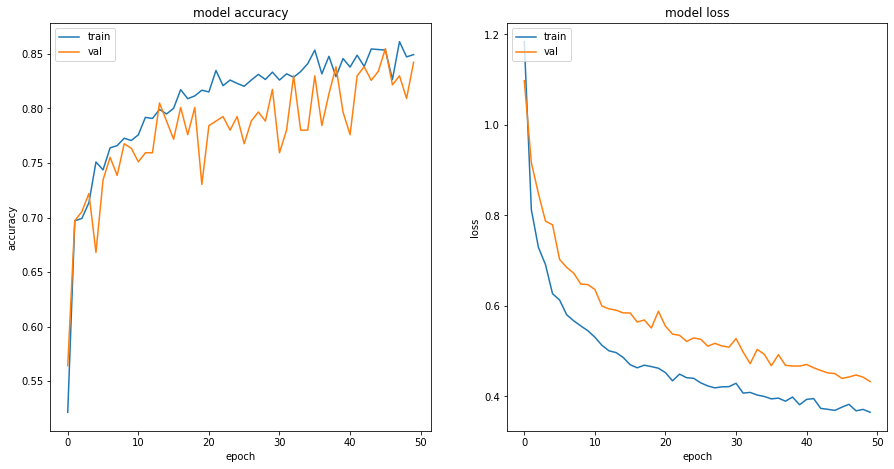

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set(ylabel='accuracy', xlabel='epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set(ylabel='loss', xlabel='epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
y_true, y_pred = [], []
for imgs, lbls in test_data.take(len(test_data)):
    y_true.append(lbls.numpy())
    y_pred.append(model.predict(imgs))

y_pred = np.argmax(np.concatenate(y_pred), axis=1) 
y_true = np.argmax(np.concatenate(y_true), axis=1)   

print(cr(y_pred=y_pred, y_true=y_true))
print(cm(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81        30
           1       0.75      0.73      0.74        41
           2       0.90      0.85      0.88        55
           3       0.77      0.87      0.82        39
           4       1.00      0.87      0.93        77

    accuracy                           0.85       242
   macro avg       0.83      0.85      0.84       242
weighted avg       0.86      0.85      0.85       242

[[28  2  0  0  0]
 [11 30  0  0  0]
 [ 0  8 47  0  0]
 [ 0  0  5 34  0]
 [ 0  0  0 10 67]]


In [17]:
# Fine tuning
FINE_TUNE_EPOCHS = 20

base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 200
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(
    optimizer=tf.optimizers.Adam(LEARNING_RATE / 10),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

print(model.summary())

history_fine = model.fit(train_data, validation_data=val_data, epochs=EPOCHS+FINE_TUNE_EPOCHS, initial_epoch=EPOCHS, verbose=1)

model.save_weights(f'EfficientNetB3_ExtYaleBCropped_FineTuned.h5')

model.evaluate(test_data)

Number of layers in the base model:  385
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
pred_light (Dense)           (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 9,815,675
Non-trainable params: 975,545
_________________________________________________________________
None
Epoch 51/70
31/31 [==============================] - 31s 591ms/s

[0.026230184361338615, 0.9917355179786682]

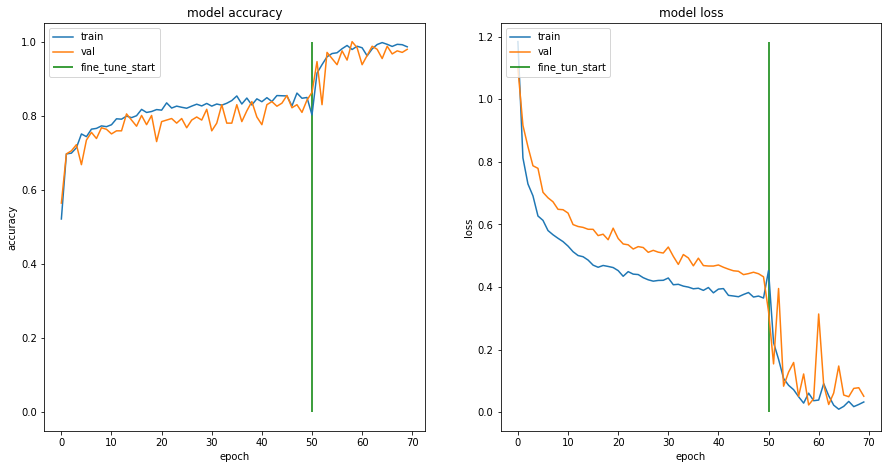

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
acc = history.history['categorical_accuracy'] + history_fine.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy'] + history_fine.history['val_categorical_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

ax1.plot(acc)
ax1.plot(val_acc)
ax1.set_title('model accuracy')
ax1.set(ylabel='accuracy', xlabel='epoch')
ax1.vlines(EPOCHS, 0, 1, colors='green')
ax1.legend(['train', 'val', 'fine_tune_start'], loc='upper left')


ax2.plot(loss)
ax2.plot(val_loss)
ax2.set_title('model loss')
ax2.set(ylabel='loss', xlabel='epoch')
ax2.vlines(EPOCHS, 0, max(loss), colors='green')
ax2.legend(['train', 'val', 'fine_tun_start'], loc='upper left')

plt.show()

In [19]:
y_true, y_pred = [], []
for imgs, lbls in test_data.take(len(test_data)):
    y_true.append(lbls.numpy())
    y_pred.append(model.predict(imgs))

y_pred = np.argmax(np.concatenate(y_pred), axis=1) 
y_true = np.argmax(np.concatenate(y_true), axis=1)   

print(cr(y_pred=y_pred, y_true=y_true))
print(cm(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.98      0.99        41
           2       0.98      0.98      0.98        55
           3       0.97      1.00      0.99        39
           4       1.00      1.00      1.00        77

    accuracy                           0.99       242
   macro avg       0.99      0.99      0.99       242
weighted avg       0.99      0.99      0.99       242

[[30  0  0  0  0]
 [ 0 40  1  0  0]
 [ 0  0 54  1  0]
 [ 0  0  0 39  0]
 [ 0  0  0  0 77]]
